In [263]:
import pandas as pd
import numpy as np
import random
from utils import *
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.cluster import OPTICS, cluster_optics_dbscan, KMeans
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [2]:
df = pd.read_csv('data.csv')

In [334]:
features = ['ITEMID', 'OprID', 'WORKER', 'WrkCtrID']
data = df.loc[:, features]
data.loc[:, ('WORKER')] = data['WORKER'].astype(str)
data.loc[:, ('WrkCtrID')] = data['WrkCtrID'].astype(str)
df['TIME_DEVIATION'] = df['CalcHours'] - df['Hours']
KDEY = clusterKDE(df['TIME_DEVIATION'])
DBSCANY = clusterDBSCAN(df['TIME_DEVIATION'], eps=5, min_samples=5)

# OPTICS
clust = OPTICS(max_eps=4, min_samples=5, xi=0.1, min_cluster_size=.05)
targets = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
clust.fit(targets)
OPTICSY = clust.labels_

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=6, covariance_type='spherical')
targets = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
gmm.fit(targets)
GMMY = gmm.predict(targets)

# Kmeans
kmeans = KMeans(n_clusters=6).fit(targets)
KmeansY = kmeans.labels_

df['cluster'] = DBSCANY
timeX = data.loc[:]

/Users/Mr_ren/.virtualenvs/thesis/lib/python3.8/site-packages/sklearn/cluster/_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


# Clustering Performance Evaluation

In [289]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, DBSCANY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, DBSCANY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, DBSCANY))

Silhouette Coefficient 0.8620279028894456
Calinski-Harabasz Index 69.37154221180448
Davies-Bouldin Index 1.9432758337489442


In [290]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, OPTICSY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, OPTICSY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, OPTICSY))

Silhouette Coefficient -0.09416026284853614
Calinski-Harabasz Index 0.15248368976449425
Davies-Bouldin Index 5.375237414055704


In [291]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, GMMY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, GMMY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, GMMY))

Silhouette Coefficient 0.7917184440266977
Calinski-Harabasz Index 17492.474972545082
Davies-Bouldin Index 0.3656079167938975


In [292]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, KDEY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, KDEY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, KDEY))

Silhouette Coefficient -0.42064524081097016
Calinski-Harabasz Index 10.667491080182977
Davies-Bouldin Index 1.0312477936042566


In [300]:
X = df['TIME_DEVIATION'].to_numpy().reshape(-1, 1)
print("Silhouette Coefficient", metrics.silhouette_score(X, KmeansY, metric='euclidean'))
print("Calinski-Harabasz Index", metrics.calinski_harabasz_score(X, KmeansY))
print("Davies-Bouldin Index", metrics.davies_bouldin_score(X, KmeansY))

Silhouette Coefficient 0.9322873232749874
Calinski-Harabasz Index 37962.036796797154
Davies-Bouldin Index 0.22077407257359552


In [327]:
def set_custom_color(series, max_color = 'turquoise', other_color = 'lightgrey', highest=True):
    max_val = max(series) if highest else min(series)
    colors = []
    
    for item in series:
        if item == max_val:
            colors.append(max_color)
        else:
            colors.append(other_color)
    return colors

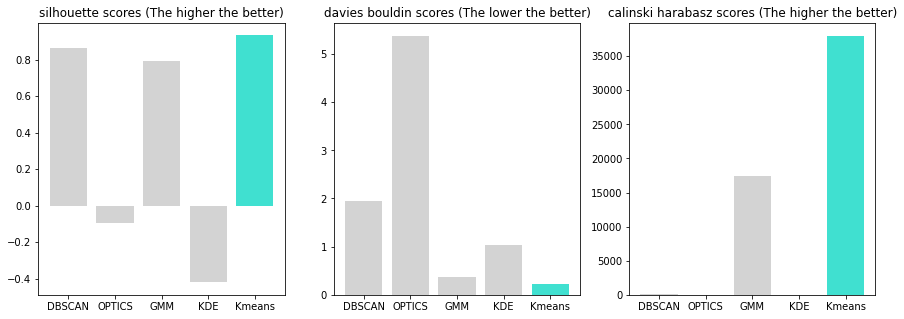

In [332]:
Ys = [DBSCANY, OPTICSY, GMMY, KDEY, KmeansY]
Names = ['DBSCAN', 'OPTICS', 'GMM', 'KDE', 'Kmeans']
silhouette_scores = [metrics.silhouette_score(X, item, metric='euclidean') for item in Ys]
calinski_harabasz_scores = [metrics.calinski_harabasz_score(X, item) for item in Ys]
davies_bouldin_scores = [metrics.davies_bouldin_score(X, item) for item in Ys]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

axs[0].bar(Names, silhouette_scores, color=set_custom_color(silhouette_scores))
axs[0].set_title('silhouette scores (The higher the better)')
axs[1].bar(Names, davies_bouldin_scores, color=set_custom_color(davies_bouldin_scores, highest=False))
axs[1].set_title('davies bouldin scores (The lower the better)')
axs[2].bar(Names, calinski_harabasz_scores, color=set_custom_color(calinski_harabasz_scores))
axs[2].set_title('calinski harabasz scores (The higher the better)')
plt.show()

In [302]:
timeY = KmeansY

In [303]:
Counter(timeY)

Counter({0: 1042, 3: 11, 1: 3, 5: 3, 4: 30, 2: 7})

In [296]:
timeModel = svm.SVC(class_weight='balanced')

In [304]:
oversampleRates = [i / 10 for i in range(4, 11)]

for rate in oversampleRates:
    timeSampleDict = getSampleDict(timeY, overSampleRate=rate)
    timePipeline = getResamplePipeline(timeSampleDict, k_neighbors=2, withUnder=True)
    timeX_res, timeY_res = timePipeline.fit_resample(timeX, timeY)
    print('Sample rate {0}, Accuracy {1}'.format(rate, crossValidate(timeModel, timeX_res, timeY_res, 3, 3)))

Sample rate 0.4, Accuracy 0.7652184746947248
Sample rate 0.5, Accuracy 0.7689331562370807
Sample rate 0.6, Accuracy 0.7758618333209206
Sample rate 0.7, Accuracy 0.7734137475935433
Sample rate 0.8, Accuracy 0.7785174301457827
Sample rate 0.9, Accuracy 0.7787839458632141
Sample rate 1.0, Accuracy 0.7818825780325818


# Pattern Distribution

<AxesSubplot:xlabel='Time hours', ylabel='Frequency'>

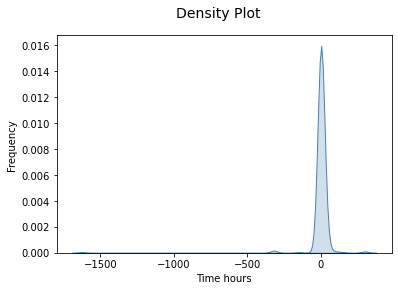

In [76]:
fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("Density Plot", fontsize=14)
# fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,1, 1)
ax1.set_xlabel("Time hours")
ax1.set_ylabel("Frequency") 
sns.kdeplot(df['TIME_DEVIATION'], ax=ax1, shade=True, color='steelblue')

# Visualize Clustering Results

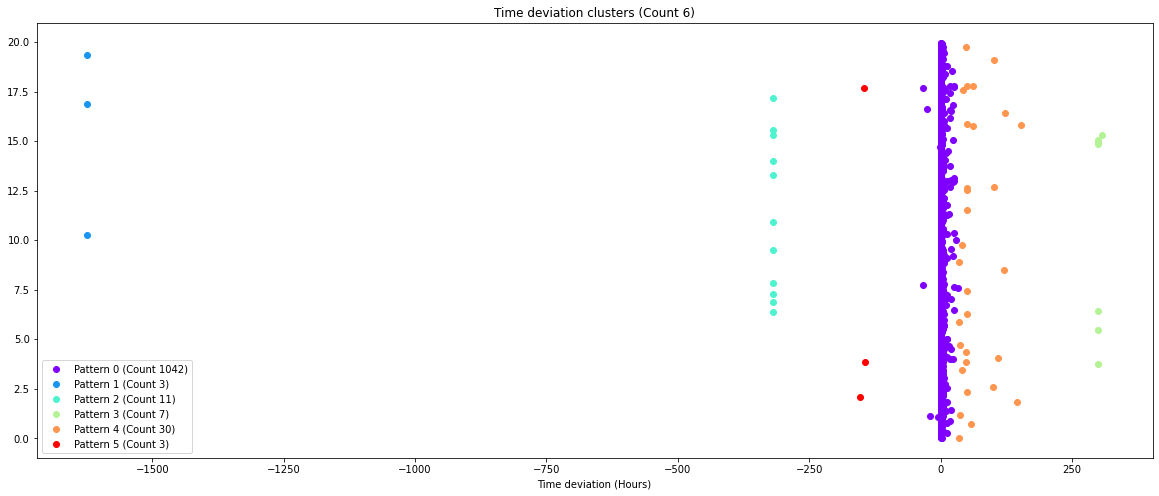

In [340]:
fig, ax = plt.subplots(figsize = (20, 8))
colors = cm.rainbow(np.linspace(0, 1, len(Counter(timeY))))
n_clusters = len(Counter(timeY))
df['cluster'] = KmeansY
for i, cluster in df.groupby('cluster'):
    y = []
    for _ in range(len(cluster['TIME_DEVIATION'])):
        y.append(random.random() * 20)
    label = 'Outlier' if i == -1 else 'Pattern ' + str(i)
    label += " (Count {0})".format(len(y))
    _ = ax.scatter(cluster['TIME_DEVIATION'], y, color=colors[i], label=label)

ax.legend(loc="lower left")
ax.set_title('Time deviation clusters ' + '(Count {})'.format(n_clusters))
ax.set_xlabel('Time deviation (Hours)')
plt.show()

# Tuning Hiper-paramters

In [341]:
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 6,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}